In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [5]:
# I don't think I need this
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [6]:
sector_zscores=sector_XS_normalized(amihud)

# Monthly portfolio sorts

In [7]:
sector_portfolio_sorts_mon={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_mon[s]=quantile_portfolios_monthly_inverse_vol(sector_zscores[s],cleansed,3)

tsmom_model.py:289: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  vol=pd.DataFrame.rolling(price_data.resample(rule='m',how='last').pct_change(),36).std().replace(0,1)
tsmom_model.py:298: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns_monthly(rank_data.resample(rule='m',how='median'),mon,number_of_buckets,i)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:3871: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  block = self.blocks[self._blknos[i]]
tsmom_model.py:308: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = (w.min()*price_data.resample(rule='m',how='last')[mkts].pct_change()[next_mon]).sum(axis=1)


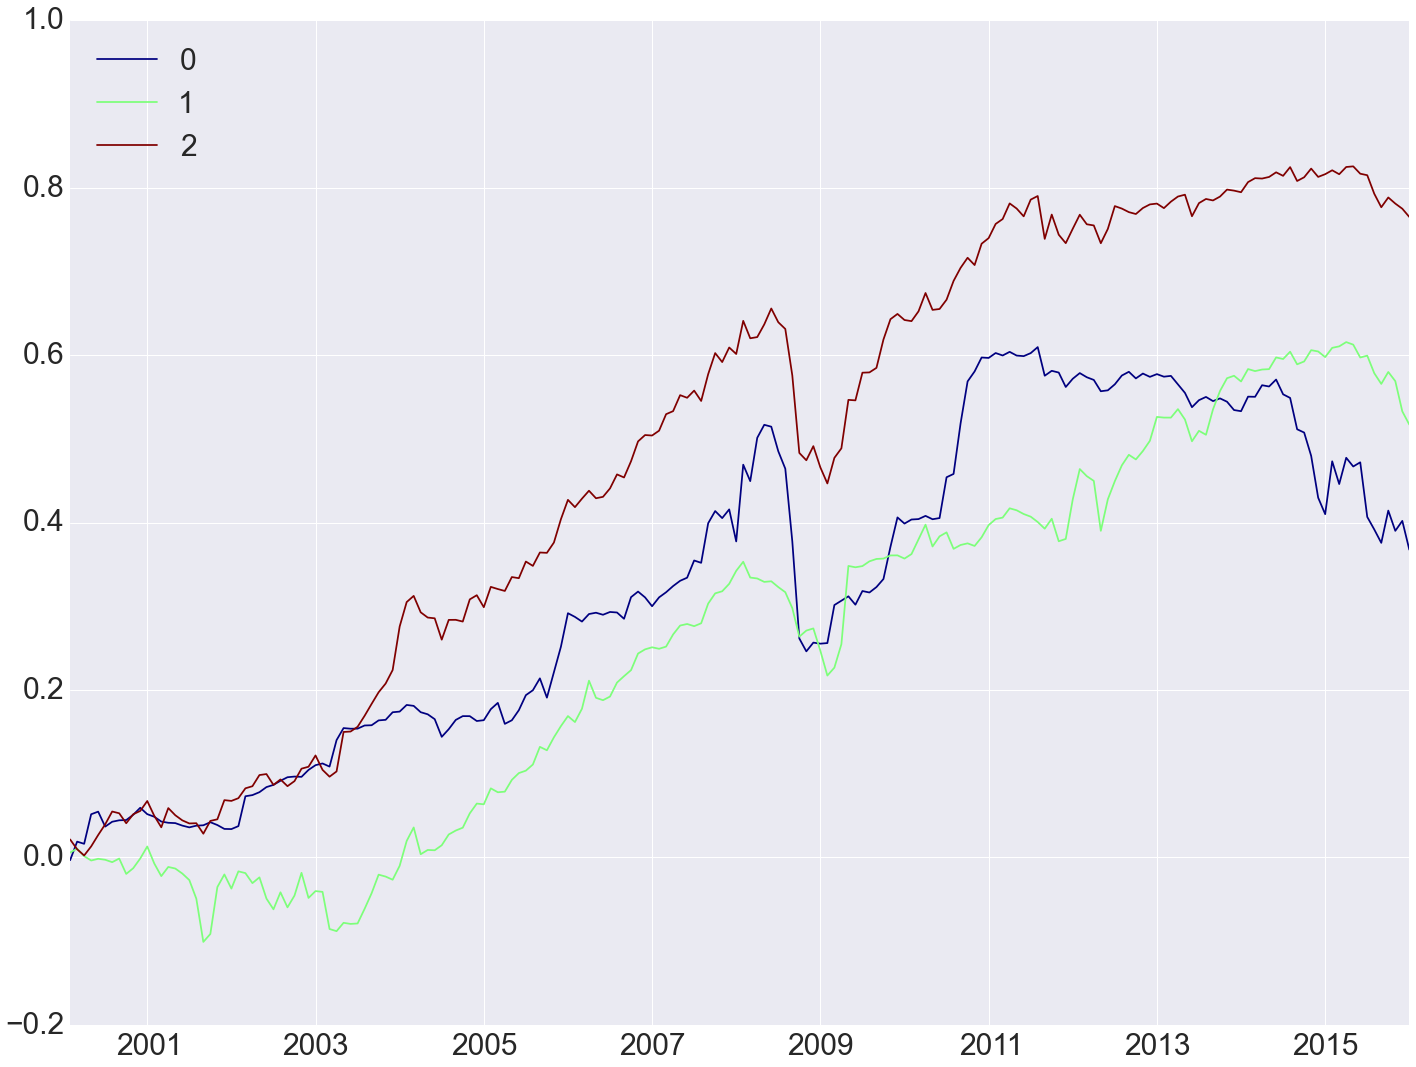

In [8]:
sector_portfolio_sorts_mon['All'].cumsum().plot(colormap='jet')

In [9]:
for s in sector_portfolio_sorts_mon.keys():
    sector_portfolio_sorts_mon[s].to_pickle('data/'+s+'_monthly_3_XS_IV.pickle')


In [10]:
all_factors=pd.DataFrame()
all_factors['Amihud Monthly']=(sector_portfolio_sorts_mon['All']['2']-sector_portfolio_sorts_mon['All']['0'])

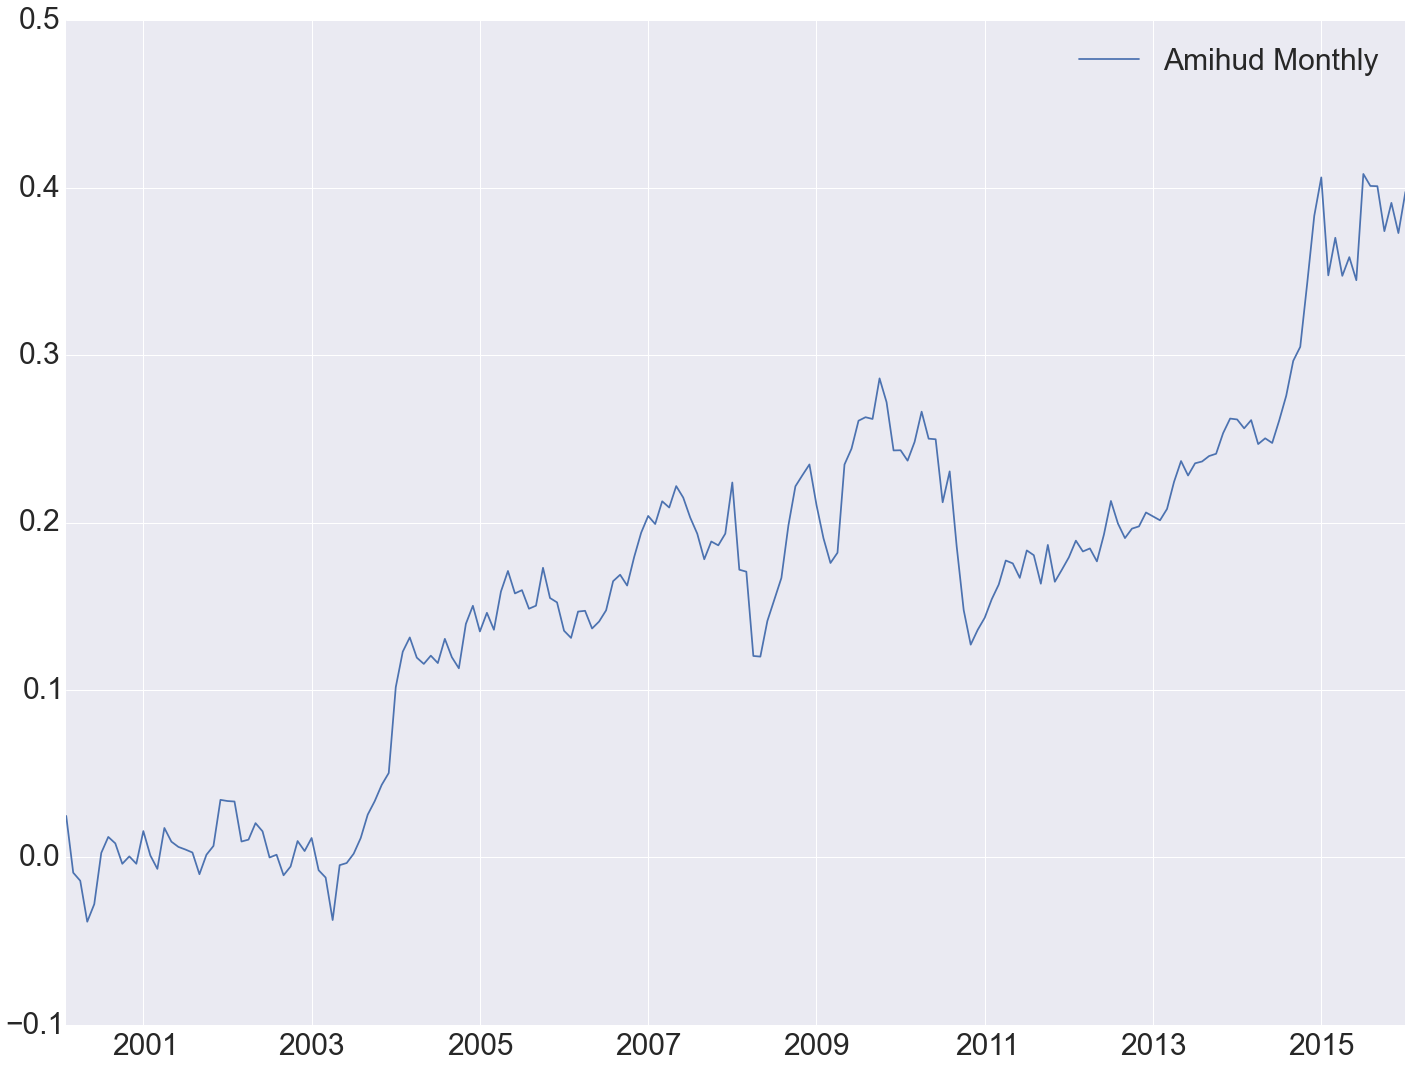

In [11]:
all_factors.cumsum().plot()

In [12]:
FHT=calculate_FHT(cleansed)
sector_zscores=sector_XS_normalized(FHT)

tsmom_model.py:360: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:361: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:362: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:362: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [13]:
sector_portfolio_sorts_FHT_mon={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_FHT_mon[s]=quantile_portfolios_monthly_inverse_vol(sector_zscores[s].dropna(how='all'),cleansed,3)


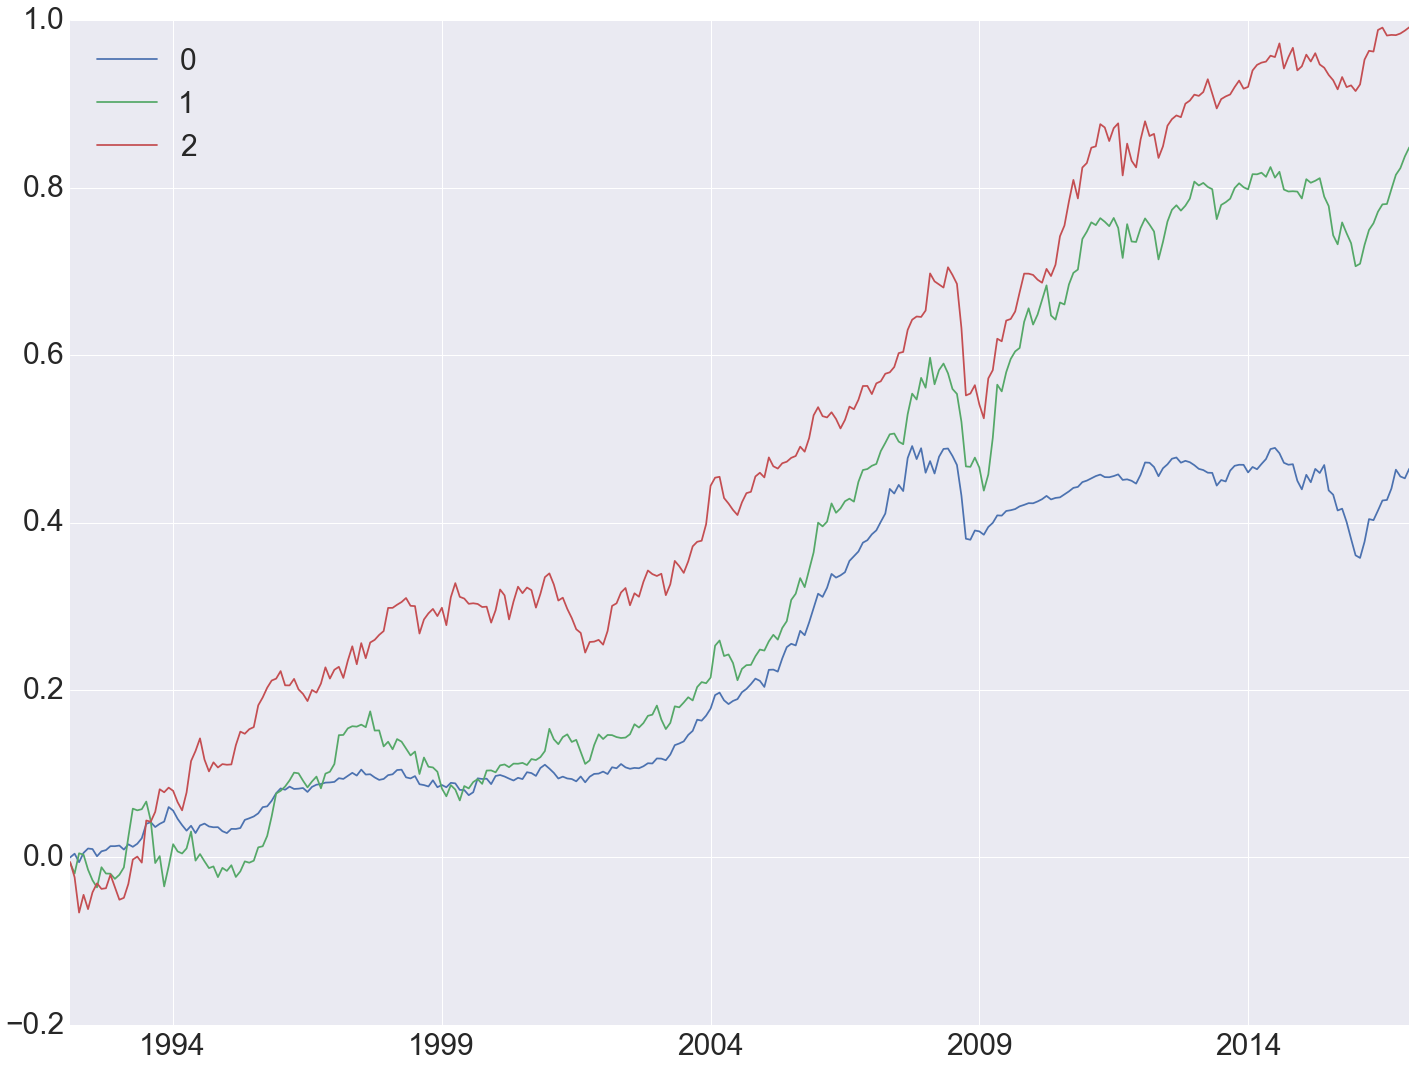

In [14]:
sector_portfolio_sorts_FHT_mon['All'].cumsum().plot()

In [15]:
for s in sector_portfolio_sorts_FHT_mon.keys():
    sector_portfolio_sorts_FHT_mon[s].to_pickle('data/'+s+'_monthly_FHT_3_XS_IV.pickle')

In [16]:
all_factors['FHT Monthly']=(sector_portfolio_sorts_FHT_mon['All']['2']-sector_portfolio_sorts_FHT_mon['All']['0'])

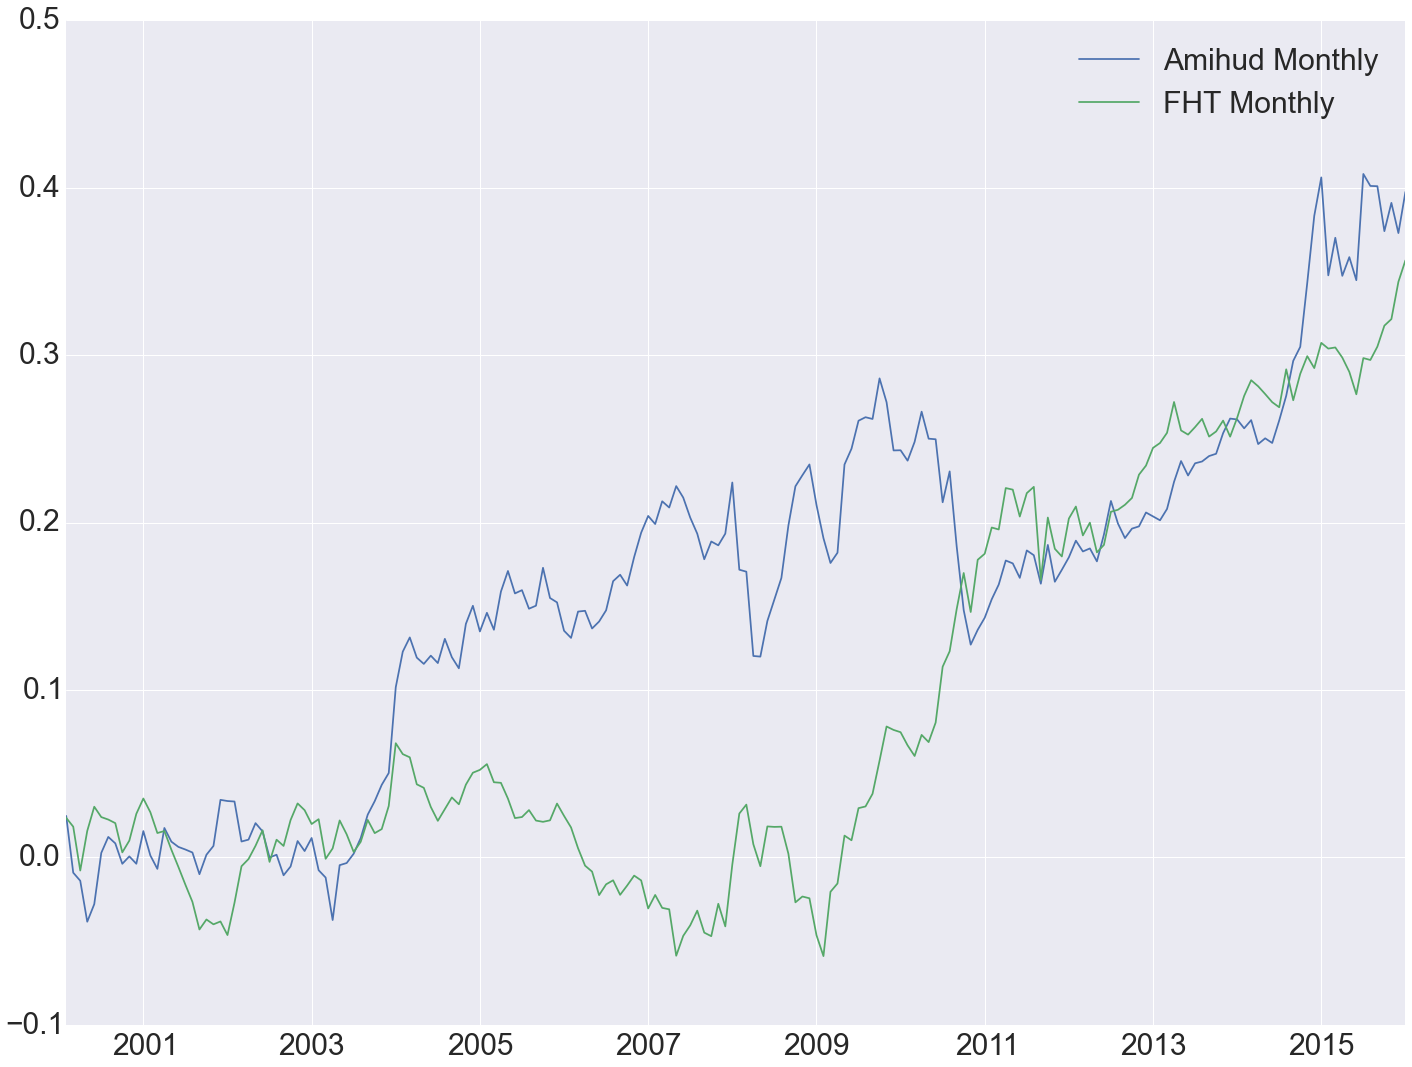

In [17]:
all_factors.cumsum().plot()

# Annual sorts

In [18]:
sector_zscores=sector_XS_normalized(amihud)

In [19]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual_inverse_vol(sector_zscores[s].dropna(how='all'),cleansed,3)

tsmom_model.py:249: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  vol=pd.DataFrame.rolling(price_data.resample(rule='m',how='last').pct_change(),36).std().replace(0,1)
tsmom_model.py:257: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:261: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = w.multiply(price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)]).sum(axis=1)


In [20]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']

In [21]:
all_factors['Amihud Annual']=factors['All']

FHT Annual sorts

In [22]:
sector_zscores=sector_XS_normalized(FHT)

In [23]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s].dropna(how='all'),cleansed,3)

tsmom_model.py:240: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:241: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [24]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


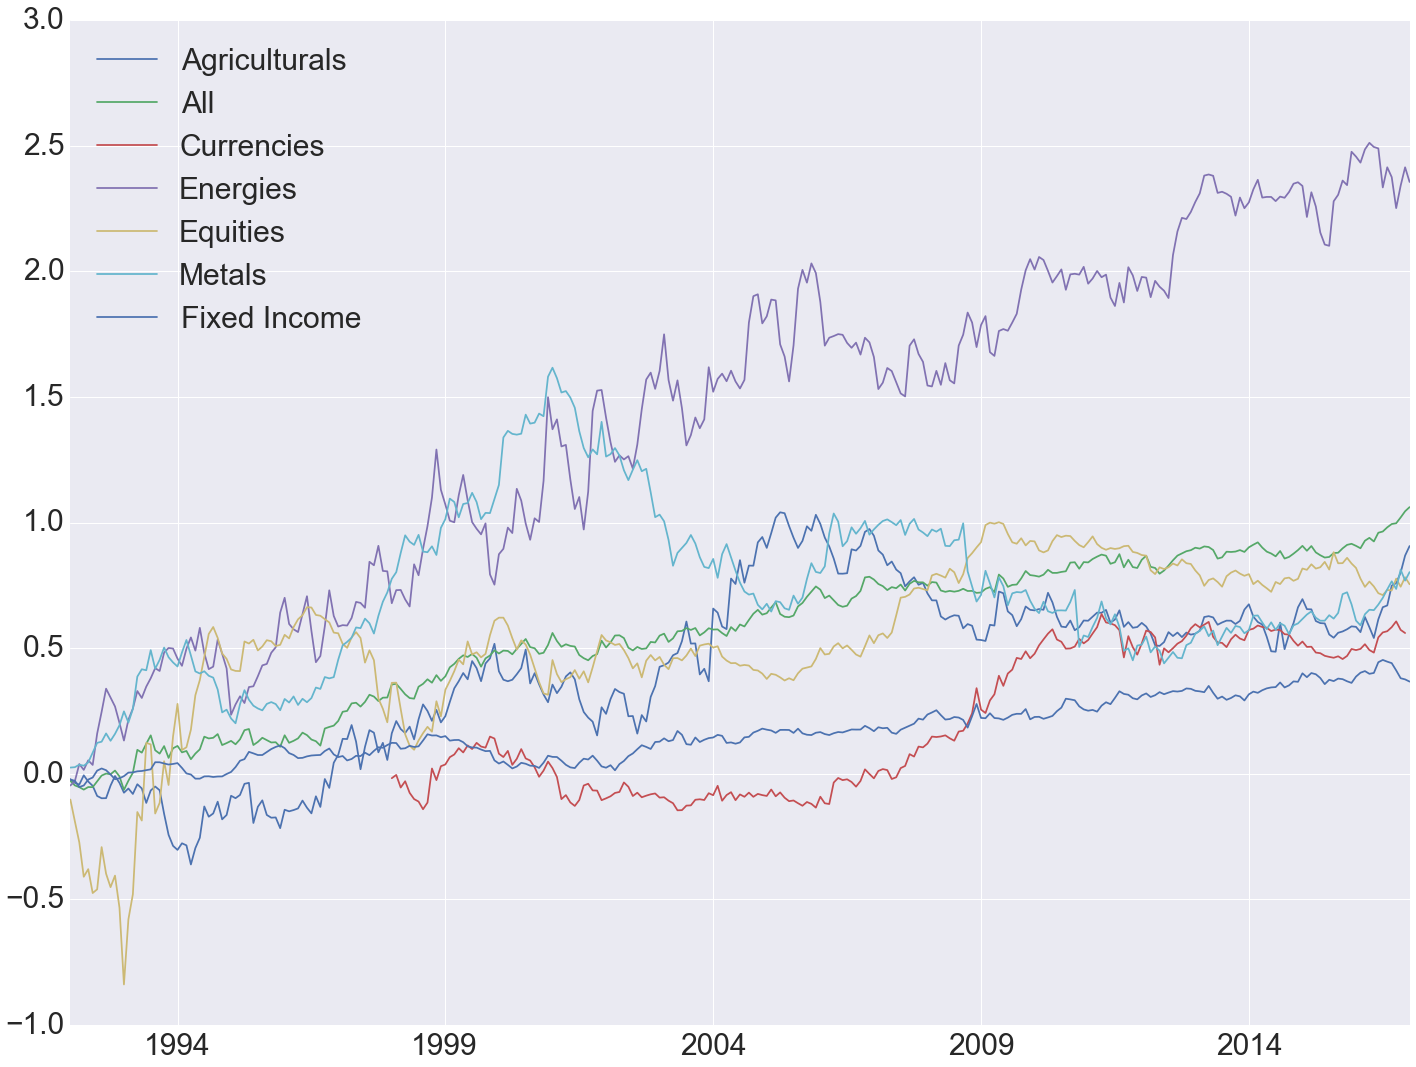

In [25]:
factors_FHT.cumsum().plot()


In [26]:
all_factors['FHT Annual']=factors_FHT['All']

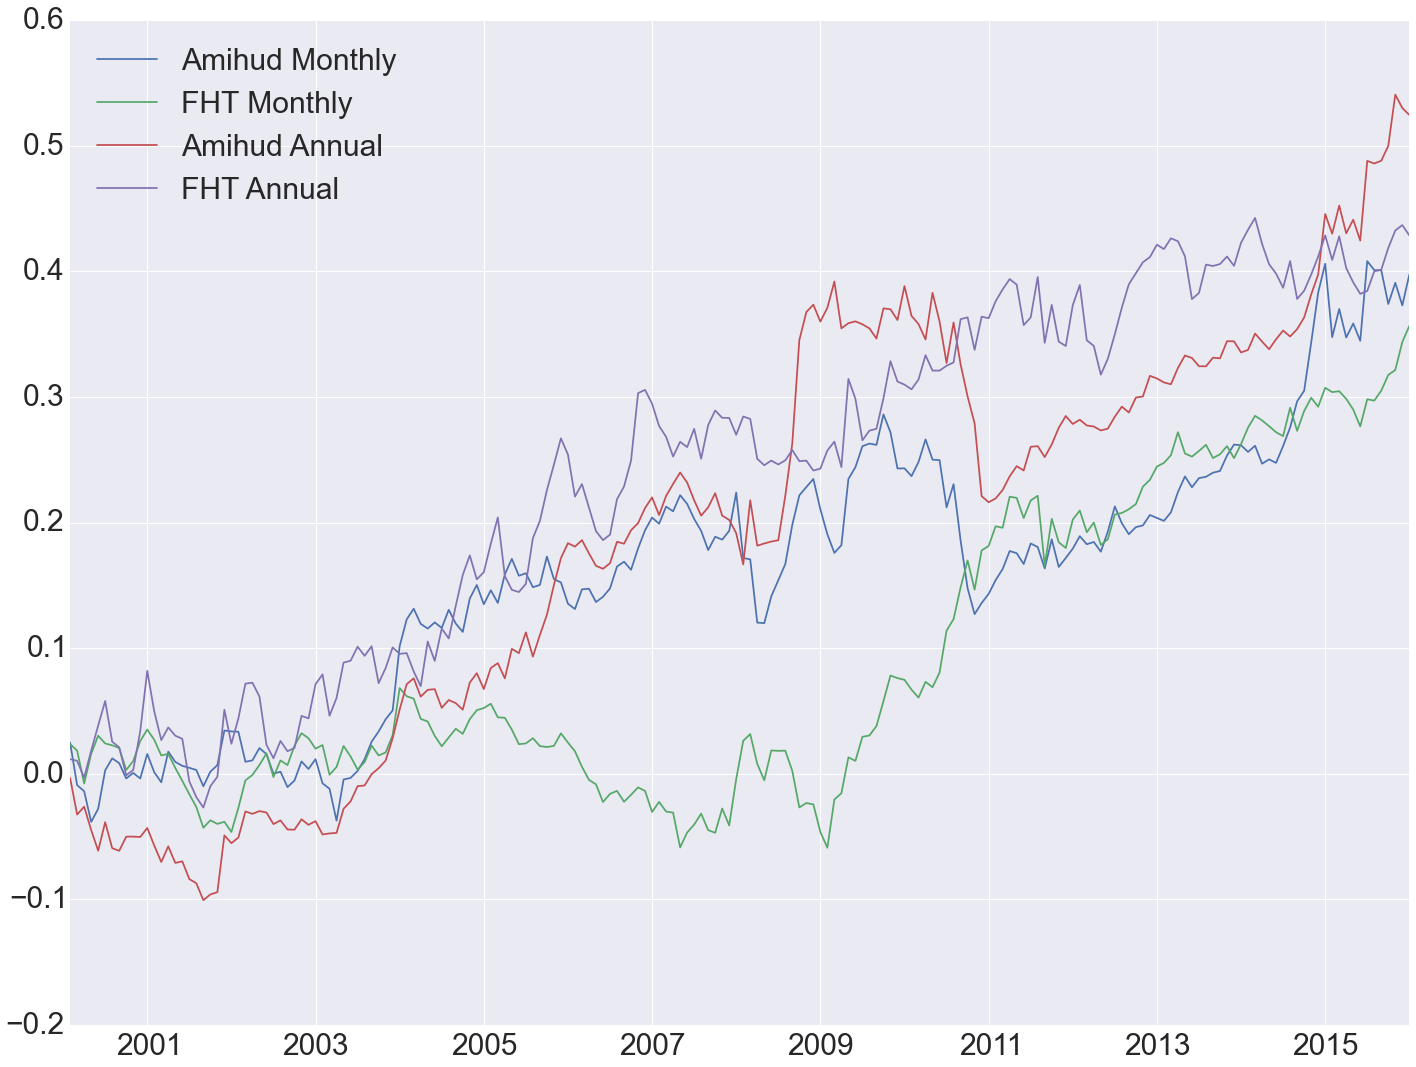

In [27]:
all_factors.cumsum().plot()

In [28]:
all_factors.to_csv('all_market_factor_3_XS_IV.csv')

In [30]:
liquidity_factors=all_factors

In [31]:
final_res=pd.DataFrame()
r2=pd.Series()
rmse=pd.Series()
alpha={}
tstat={}
for sec in liquidity_factors.columns:
    ind=liquidity_factors.dropna().index
    reges=get_aqr_factors('All').loc[ind]
    reges['Market Return']=cleansed.resample(rule='m',how='last').pct_change().mean(axis=1).dropna()
    reges['const']=1
    
    res=sm.OLS(liquidity_factors[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    final_res[sec]=res.params
    final_res[sec+'Tstats']=res.tvalues
    r2[sec]=res.rsquared
    rmse[sec]=math.sqrt(res.mse_model)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


In [33]:
final_res.T.round(3)[['const', u'Market Return','VAL', u'MOM','TSMOM','CARRY' ]]

,const,Market Return,VAL,MOM,TSMOM,CARRY
Amihud Monthly,0.003,-0.013,-0.218,-0.163,0.096,-0.080
Amihud MonthlyTstats,2.030,-0.169,-2.431,-1.839,2.020,-1.032
FHT Monthly,0.000,0.268,-0.116,-0.135,0.066,0.016
FHT MonthlyTstats,0.374,5.088,-1.776,-2.471,2.188,0.325
Amihud Annual,0.004,-0.159,-0.168,-0.174,0.118,-0.097
Amihud AnnualTstats,2.773,-1.757,-2.114,-2.303,2.485,-1.396
FHT Annual,0.001,0.301,-0.262,-0.328,0.123,-0.014
FHT AnnualTstats,0.697,4.092,-3.526,-3.908,3.037,-0.199


In [35]:
print final_res.T.round(3)[['const', u'Market Return','VAL', u'MOM','TSMOM','CARRY' ]].to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  const &  Market Return &    VAL &    MOM &  TSMOM &  CARRY \\
\midrule
Amihud Monthly       &  0.003 &         -0.013 & -0.218 & -0.163 &  0.096 & -0.080 \\
Amihud MonthlyTstats &  2.030 &         -0.169 & -2.431 & -1.839 &  2.020 & -1.032 \\
FHT Monthly          &  0.000 &          0.268 & -0.116 & -0.135 &  0.066 &  0.016 \\
FHT MonthlyTstats    &  0.374 &          5.088 & -1.776 & -2.471 &  2.188 &  0.325 \\
Amihud Annual        &  0.004 &         -0.159 & -0.168 & -0.174 &  0.118 & -0.097 \\
Amihud AnnualTstats  &  2.773 &         -1.757 & -2.114 & -2.303 &  2.485 & -1.396 \\
FHT Annual           &  0.001 &          0.301 & -0.262 & -0.328 &  0.123 & -0.014 \\
FHT AnnualTstats     &  0.697 &          4.092 & -3.526 & -3.908 &  3.037 & -0.199 \\
\bottomrule
\end{tabular}



In [36]:
df=pd.DataFrame()
df['R2']=(r2*100).round(2)
df['rmse']=rmse.round(3)

In [37]:
print df.to_latex()

\begin{tabular}{lrr}
\toprule
{} &     R2 &   rmse \\
\midrule
Amihud Monthly &   5.60 &  0.026 \\
FHT Monthly    &  27.27 &  0.046 \\
Amihud Annual  &  13.14 &  0.039 \\
FHT Annual     &  22.94 &  0.058 \\
\bottomrule
\end{tabular}

